In [1]:
import cv2
import math
import numpy as np
import pathlib
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import einops
import video_tools

DEBUG = False

2023-02-19 00:18:14.428947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 00:18:15.104919: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fletchersarip/anaconda3/envs/tensorflow/lib/python3.10/site-packages/cv2/../../lib64::/home/fletchersarip/anaconda3/envs/tensorflow/lib/
2023-02-19 00:18:15.105046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_L

Below I'll show the GIF of the filtered frames. I simulate a "collision" of my hands in the test video that I'm using. My hands collide at around timestamp 1500 msec. The code then extract a set of frames which include the exact frame at timestamp 1500 msec so we have the frame at the exact moment when my hand "collided".

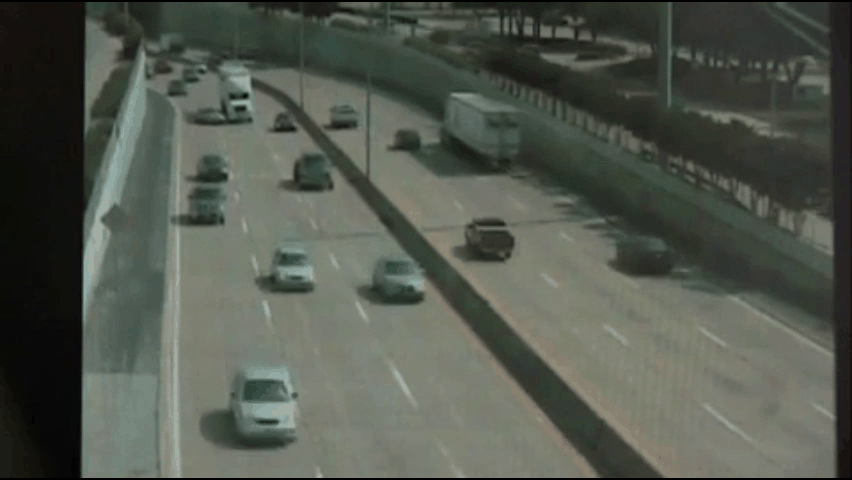

In [2]:
# Example frames in GIF

import imageio
from IPython.display import Image

tmp_dir = './tmp'
pathlib.Path(tmp_dir).mkdir(parents=True, exist_ok=True)

video_filepath = 'data/traffic_accident_videos/videos/traffic_accident_1.mp4'
gif_out_file_path = f'{tmp_dir}/test.gif'

frame_index_sequences, labels = video_tools.get_frame_indexes_surrounding_event(video_filepath, event_timestamp_millis=5790, sequence_length=11, frame_step=10)
vid_frames = video_tools.get_image_frames(video_filepath, frame_index_sequences)

imageio.mimsave(gif_out_file_path, vid_frames[5], fps=10)
Image(filename=gif_out_file_path)

In [3]:
# format image frame before input to model
HEIGHT = 224
WIDTH = 224

def format_image_frame(frame):
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, HEIGHT, WIDTH)
    frame = tf.image.rgb_to_grayscale(frame)
    
    return frame.numpy()

In [4]:
# create dataset
labels_file_path_train = './data/traffic_accident_videos/labels_train.csv'
labels_file_path_val = './data/traffic_accident_videos/labels_val.csv'
videos_dir_path = './data/traffic_accident_videos/videos/'
batch_size = 20
sequence_length = 15
frame_step_size = 5
min_proportion_of_after_event_frames = 0.3
max_proportion_of_after_event_frames = 0.8
NUM_CHANNEL = 1

frame_generator_train = video_tools.FrameGenerator(videos_dir_path=videos_dir_path,
                                             labels_file_path=labels_file_path_train,
                                             sequence_length=sequence_length,
                                             frame_step_size=frame_step_size,
                                             min_proportion_of_after_event_frames=min_proportion_of_after_event_frames,
                                             max_proportion_of_after_event_frames=max_proportion_of_after_event_frames,
                                             num_sequences_for_no_event_videos=40,
                                             format_frame_fn=format_image_frame)

frame_generator_val = video_tools.FrameGenerator(videos_dir_path=videos_dir_path,
                                             labels_file_path=labels_file_path_val,
                                             sequence_length=sequence_length,
                                             frame_step_size=frame_step_size,
                                             min_proportion_of_after_event_frames=min_proportion_of_after_event_frames,
                                             max_proportion_of_after_event_frames=max_proportion_of_after_event_frames,
                                             num_sequences_for_no_event_videos=5,
                                             format_frame_fn=format_image_frame)

output_signature = (tf.TensorSpec(shape=(None, None, None, NUM_CHANNEL), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.uint8))

train_ds = tf.data.Dataset.from_generator(frame_generator_train, output_signature=output_signature)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE).cache().shuffle(buffer_size=200, reshuffle_each_iteration=True).repeat().batch(batch_size)

val_ds = tf.data.Dataset.from_generator(frame_generator_val, output_signature=output_signature)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE).cache().batch(batch_size)

# test
ratio_of_ones_train = []

for frames, labels in train_ds.take(10):
    assert frames.shape == (batch_size, sequence_length, HEIGHT, WIDTH, NUM_CHANNEL)
    assert labels.shape == (batch_size,)
    ratio_of_ones_train.append(np.mean(labels))

print('All tests OK.')
print(f'Class balance evaluation for training dataset: {np.mean(ratio_of_ones_train)}')

ratio_of_ones_val = []

for frames, labels in val_ds.take(10):
    assert frames.shape[1:] == (sequence_length, HEIGHT, WIDTH, NUM_CHANNEL)
    ratio_of_ones_val.append(np.mean(labels))

print('All tests OK.')
print(f'Class balance evaluation for training dataset: {np.mean(ratio_of_ones_val)}')

2023-02-19 00:18:16.937622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-19 00:18:16.943302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-19 00:18:16.943342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-19 00:18:16.943874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

All tests OK.
Class balance evaluation for training dataset: 0.43500000000000005
All tests OK.
Class balance evaluation for training dataset: 0.4


In [5]:
class Conv2Plus1D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding):
        super().__init__()
        self.seq = keras.Sequential([
            keras.layers.Conv3D(filters=filters,
                          kernel_size=(1, kernel_size[1], kernel_size[2]),
                          padding=padding),
            keras.layers.Conv3D(filters=filters,
                          kernel_size=(kernel_size[0], 1, 1),
                          padding=padding)
        ])
    
    def call(self, x):
        return self.seq(x)
    
class ResidualMain(keras.layers.Layer):
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.seq = keras.Sequential([
            Conv2Plus1D(filters=filters,
                        kernel_size=kernel_size,
                        padding='same'),
            keras.layers.LayerNormalization(),
            keras.layers.ReLU(),
            Conv2Plus1D(filters=filters,
                        kernel_size=kernel_size,
                        padding='same'),
            keras.layers.LayerNormalization()
        ])
    
    def call(self, x):
        return self.seq(x)

class Project(keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.seq = keras.Sequential([
            keras.layers.Dense(units),
            keras.layers.LayerNormalization()
        ])
        
    def call(self, x):
        return self.seq(x)
    
def add_residual_block(input, filters, kernel_size):
    out = ResidualMain(filters=filters, kernel_size=kernel_size)(input)
    
    res = input
    if out.shape[-1] != input.shape[-1]:
        res = Project(out.shape[-1])(res)
    
    return keras.layers.add([res, out])

class ResizeVideo(keras.layers.Layer):
    def __init__(self, height, width):
        super().__init__()
        self.height = height
        self.width = width
        self.resizing_layer = keras.layers.Resizing(self.height, self.width)
        
    def call(self, video):
        old_shape = einops.parse_shape(video, 'b t h w c')
        images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
        images = self.resizing_layer(images)
        videos = einops.rearrange(images, '(b t) h w c -> b t h w c',
                                  t=old_shape['t'])
        
        return videos

In [6]:
# build the model
input = layers.Input(shape=(sequence_length, HEIGHT, WIDTH, NUM_CHANNEL))
x = input
x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = ResizeVideo(HEIGHT//2, WIDTH//2)(x)

x = add_residual_block(x, filters=16, kernel_size=(3, 3, 3))
x = ResizeVideo(HEIGHT//4, WIDTH//4)(x)

x = add_residual_block(x, filters=32, kernel_size=(3, 3, 3))
x = ResizeVideo(HEIGHT//8, WIDTH//8)(x)

x = add_residual_block(x, filters=64, kernel_size=(3, 3, 3))
x = ResizeVideo(HEIGHT//16, WIDTH//16)(x)

x = add_residual_block(x, filters=128, kernel_size=(3, 3, 3))

x = keras.layers.GlobalAveragePooling3D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1)(x)

model = keras.Model(input, x)

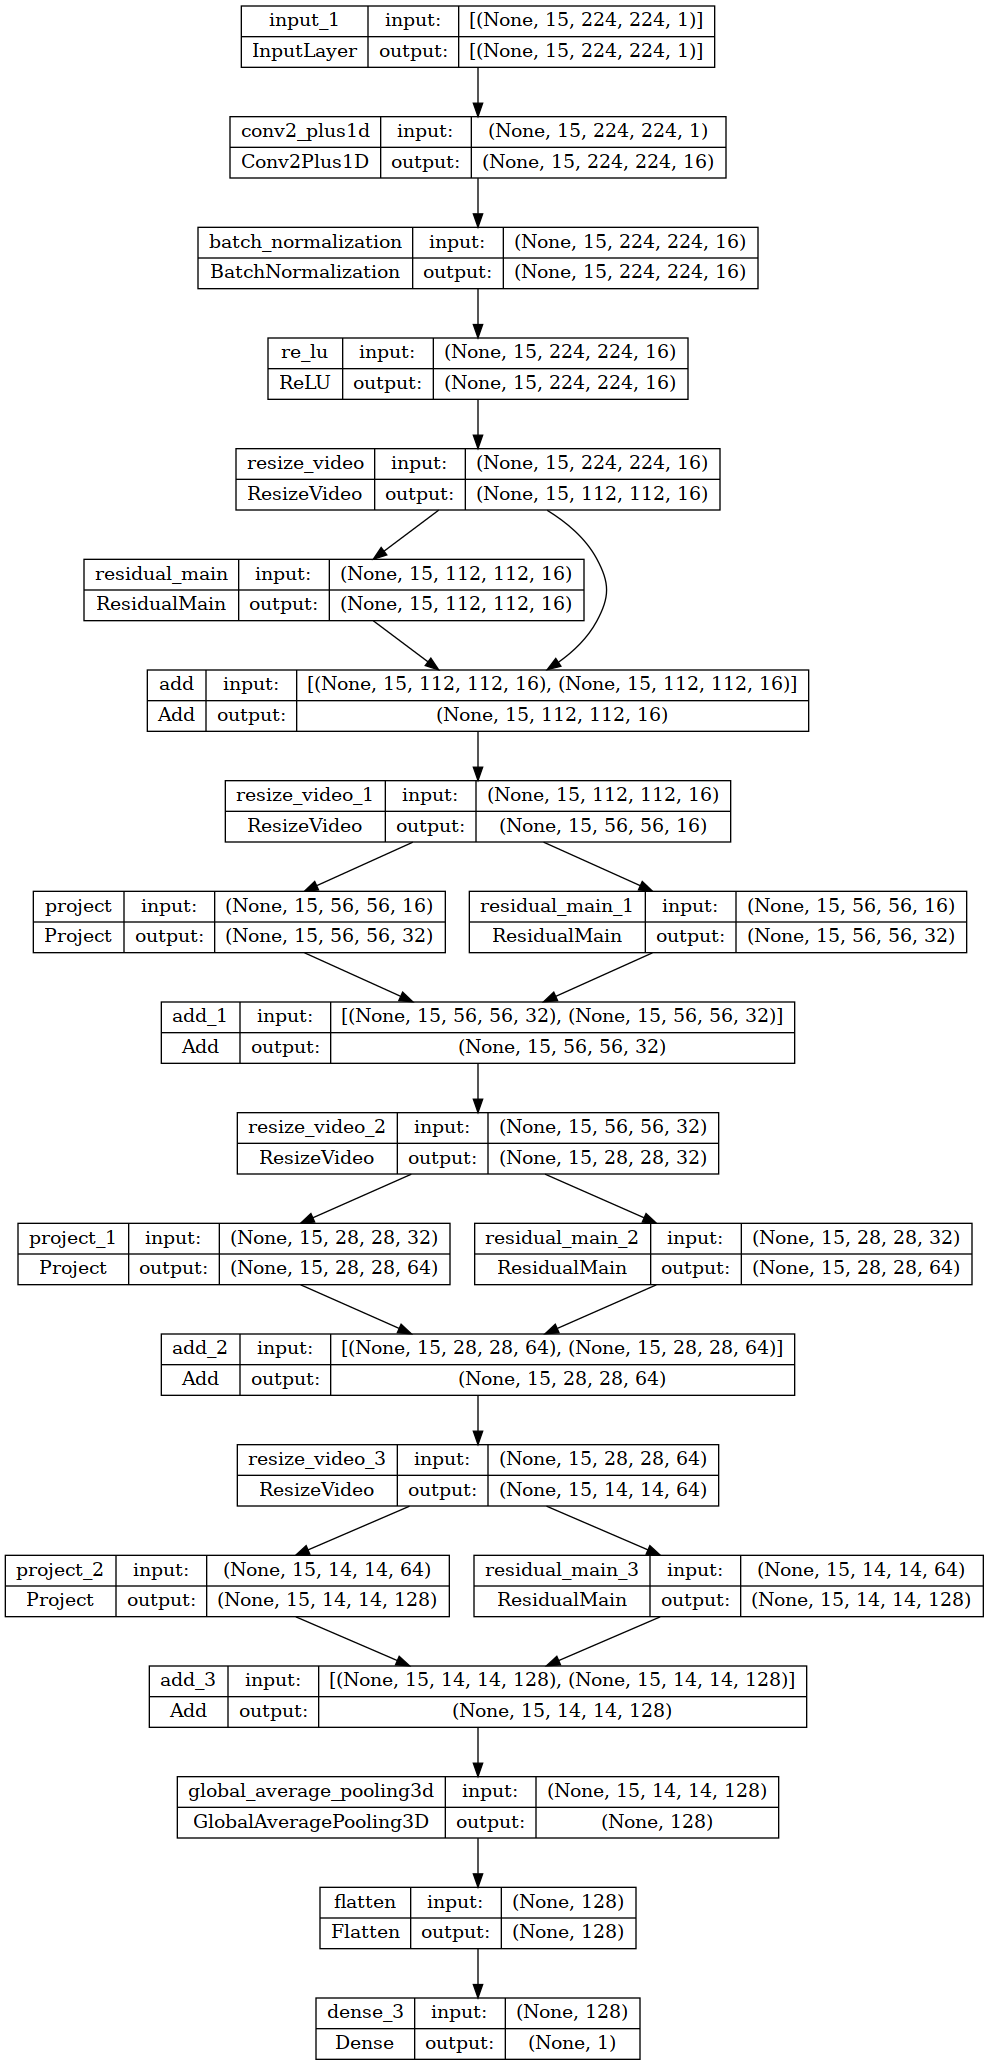

In [7]:
keras.utils.plot_model(model, show_shapes=True)

In [8]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
checkpoint_path = "./training_checkpoint/traffic_accident_detection/checkpoint"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(x=train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    steps_per_epoch=2,
                    callbacks=[cp_callback])

Epoch 1/100


2023-02-19 00:23:29.263676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-19 00:23:30.322206: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-19 00:23:31.232657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-19 00:23:31.548754: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2524bce020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-19 00:23:31.548783: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2023-02-19 00:23:31.552892: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-19 00:

2/2 [==============================] - ETA: 0s - loss: 0.7344 - accuracy: 0.7000 
Epoch 1: val_loss improved from inf to 0.78961, saving model to ./training_checkpoint/traffic_accident_detection/checkpoint
2/2 [==============================] - 18s 3s/step - loss: 0.7344 - accuracy: 0.7000 - val_loss: 0.7896 - val_accuracy: 0.6154
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.9951 - accuracy: 0.3250
Epoch 2: val_loss improved from 0.78961 to 0.77039, saving model to ./training_checkpoint/traffic_accident_detection/checkpoint
2/2 [==============================] - 3s 2s/step - loss: 0.9951 - accuracy: 0.3250 - val_loss: 0.7704 - val_accuracy: 0.0769
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.8629 - accuracy: 0.2750
Epoch 3: val_loss did not improve from 0.77039
2/2 [==============================] - 2s 1s/step - loss: 0.8629 - accuracy: 0.2750 - val_loss: 0.8065 - val_accuracy: 0.3846
Epoch 4/100
2/2 [==============================] - ETA

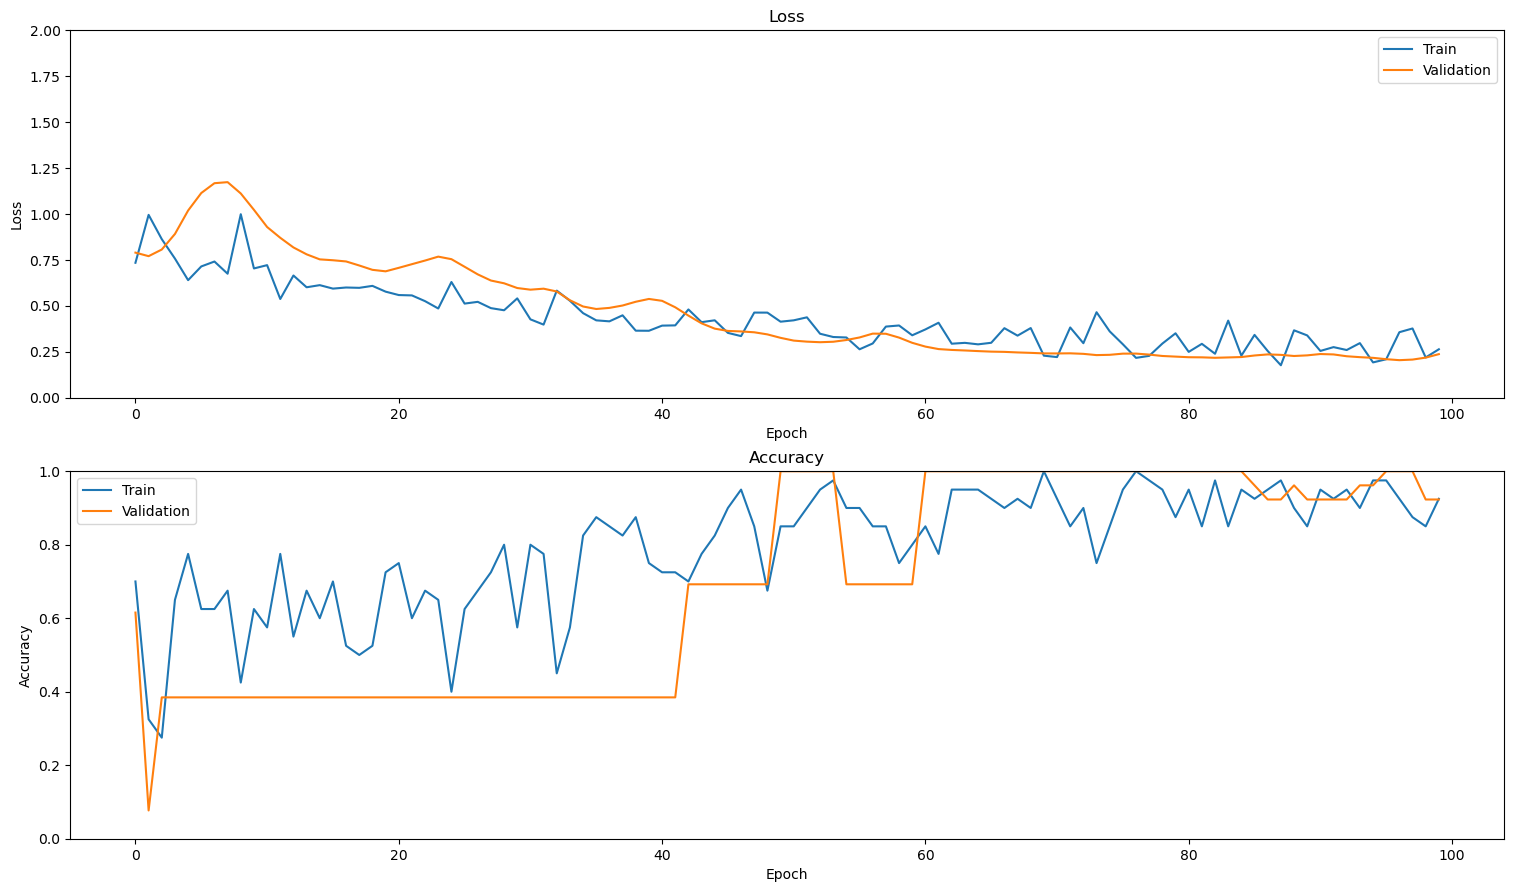

In [10]:
import matplotlib.pyplot as plt

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

### Self Notes
- It might be better to use video with the same FPS, because the model predicts based on image frame changes between frames with gap of frame_step frames. The model will see the vehicles in higher-FPS-videos as moving slower than vehicles in lower-FPS-videos.
- Other possible approach: use frame_step of 1 and increase the number of kernel-frames in the model's first layer.
- Try remove traffic_accident_2.mp4, that video is a "pedestrian" accident, which might is quite an "outlier" if compared to the other "car collission" videos.
- The vehicles in most videos stopped moving after collission happened. Let's test the model on a stationary traffic and see whether it detects the video as accident. I'm afraid the model might have cheated by simply checking for video with stationary vehicles.